# Classifying CMU Face Images

# Load libraries

In [1]:
import random
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score

In [2]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from torchvision.utils import make_grid

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split

# Check for MPS (Apple Silicon), CUDA (for Nvidia GPUs), or fallback to CPU

We're checking for different device options (MPS, CUDA, or CPU) to ensure that our PyTorch model runs on the most powerful hardware available. Running on a GPU (like CUDA or MPS) significantly speeds up computations, especially for tasks involving large datasets or deep learning models, by performing parallel processing. If no GPU is available, the code falls back to using the CPU, which is slower but still functional.

On Mac, newer Apple Silicon chips (M1/M2) support GPU acceleration through Metal Performance Shaders (MPS), which we check for to optimize performance.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device('mps')  # Metal Performance Shaders for Mac
elif torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA for Nvidia GPUs (if available on Mac)
else:
    device = torch.device('cpu')   # Fallback to CPU

print(f'Using device: {device}')

Using device: mps


# Loading/Exploring our data

We should resize the images to be 32x32 because the original LeNet-5 architecture expects input images of size 32x32, as it was originally designed for the MNIST dataset, where images have that specific resolution.

In [5]:
# Dataset transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert image to grayscale
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

In [6]:
# Load dataset
data = ImageFolder(root='../../data/mitchell_vs_everyone/faces_120x180', transform=transform)

In [7]:
print(f"There are {len(data.classes)} classes.")
print(data.classes)

There are 2 classes.
['everyone', 'mitchell']


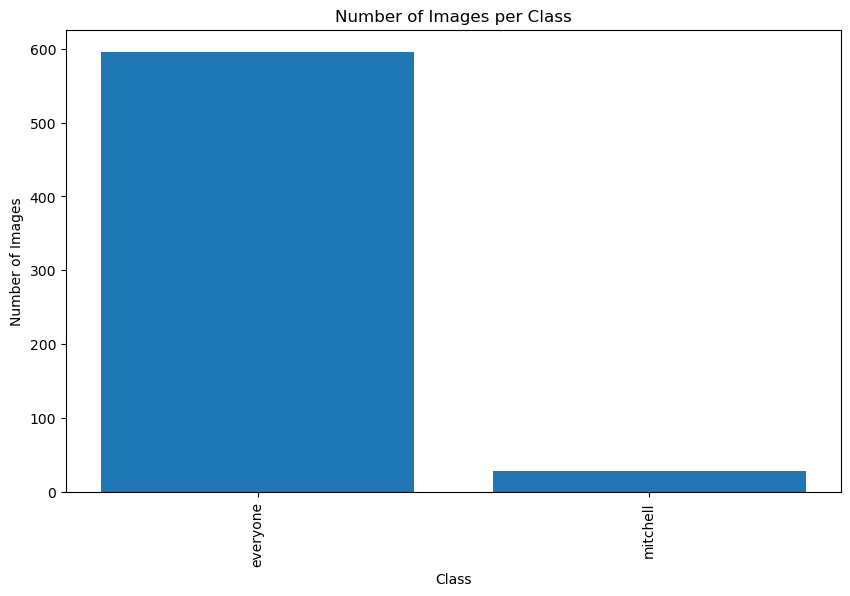

In [8]:
# Get all the labels (targets) from the dataset
labels = [label for _, label in data]

# Count the occurrences of each label
label_counts = Counter(labels)

# Get the class names and the corresponding counts
class_names = data.classes
counts = [label_counts[i] for i in range(len(class_names))]

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

In [9]:
# Calculate class weights (inverse of class frequencies)
label_counts = Counter(labels)
class_counts = [label_counts[i] for i in range(len(class_names))]
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]

In [10]:
class_weights

[1.0469798657718121, 22.285714285714285]

In [11]:
def visualize_random_images(dataset, num_images=5):
    """
    Visualizes a specified number of random images from the dataset and shows their labels.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    indices = random.sample(range(len(dataset)), num_images)
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        image = image.numpy().transpose((1, 2, 0))
        image = image * 0.5 + 0.5  # Unnormalize the image

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')

    plt.show()

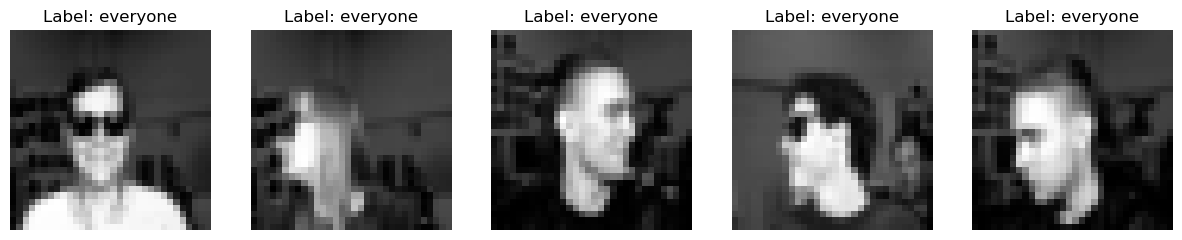

In [12]:
visualize_random_images(data)

# Train/Test/Val

In [13]:
train_size = int(0.6 * len(data))
val_size = int(0.2 * len(data))
test_size = len(data) - train_size - val_size

train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

print(f"Training set: {len(train_data)}, Validation set: {len(val_data)}, Testing set: {len(test_data)}")

Training set: 374, Validation set: 124, Testing set: 126


In [14]:
# Data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [15]:
print(f'Number of batches per epoch: {len(train_loader)}')

Number of batches per epoch: 6


# Define the LeNet-5 architecture

We switched the original 10 output features to 20 in the final fully connected layer because the number of output neurons must match the number of classes in your dataset. The original model had 10 output neurons, suitable for datasets like MNIST with 10 classes. Since your dataset has 2 classes (Mitchell vs Everyone), we need 2 output neurons.

In [16]:
# Define the LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Convolutional layer 1: 1 input channel (for grayscale images), 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # Subsampling layer (MaxPooling) with 2x2 kernel and stride 2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional layer 2: 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # Subsampling layer (MaxPooling) with 2x2 kernel and stride 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer 1: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16*5*5, 120)
        # Fully connected layer 2: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84)
        # Output layer: 84 input features, 2 output features for 2 classes (modified from original LeNet5)
        self.fc3 = nn.Linear(84, 2)

        # Activation function: ReLU will be used
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape of the image is assumed to be [batch_size, 1, 32, 32]

        # Pass the input through the first convolutional layer, then activation, then pool
        x = self.pool1(self.relu(self.conv1(x)))
        # Pass the output through the second convolutional layer, then activation, then pool
        x = self.pool2(self.relu(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Pass the flattened output through the first fully connected layer, then activation
        x = self.relu(self.fc1(x))
        # Pass the output through the second fully connected layer, then activation
        x = self.relu(self.fc2(x))
        # Pass the output through the final output layer
        x = self.fc3(x)

        return x

In [17]:
# Instantiate the network
lenet5 = LeNet5().to(device)

In [18]:
# Convert class_weights to a tensor and move to the device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [19]:
# Use CrossEntropyLoss with weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [20]:
# Optimizer (SGD is used in the original paper)
# optimizer = optim.SGD(lenet5.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(lenet5.parameters(), lr=0.001)

# Train the model

In [21]:
# Load checkpoint if it exists
checkpoint_path = 'checkpoint.pth'
start_epoch = 0
print(f'Number of batches per epoch: {len(train_loader)}')
try:
    checkpoint = torch.load(checkpoint_path, weights_only=True)
    lenet5.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    print("No checkpoint found, starting from scratch.")

Number of batches per epoch: 6
Resuming training from epoch 100


In [22]:
%%time
num_epochs = 100 # Number of epochs
early_stop_patience = 10  # Stop training if no improvement for this many epochs
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(start_epoch, num_epochs):
    lenet5.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Loop through the training batches
    for i, (images, labels) in enumerate(train_loader, 0):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # Zero the parameter gradients for proper weight updates

        # Forward pass
        outputs = lenet5(images)
        loss = criterion(outputs, labels)

        # Backward pass 
        loss.backward()

        '''
        # Monitoring Gradients
        total_norm = 0
        for name, param in lenet5.named_parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)  # L2 norm of the gradients
                total_norm += param_norm.item() ** 2
                print(f'Layer: {name} | Gradient Norm: {param_norm.item():.6f}')
        total_norm = total_norm ** 0.5
        print(f'Total Gradient Norm: {total_norm:.6f}')
        '''
        
        # Optimize
        optimizer.step()

        running_loss += loss.item()

    # Save the model checkpoint at the end of the epoch
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': lenet5.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss / len(train_loader),
    }

    torch.save(checkpoint, checkpoint_path)
    
    # Validation step
    lenet5.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for evaluation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = lenet5(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader) # Average validation loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.6f}, Validation Loss: {val_loss:.6f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print('Early stopping due to no improvement in validation loss.')
        break
    
print('Finished Training')

Finished Training
CPU times: user 2.41 ms, sys: 41 μs, total: 2.45 ms
Wall time: 145 μs


In [23]:
# After training, save the entire model (architecture + weights)
torch.save(lenet5, 'lenet5_full_model.pth')

# Evaluating the model

In [24]:
def evaluate_model(model, data_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())    

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    print(f'Balanced Accuracy: {balanced_acc * 100:.2f}%')

    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Macro F1 Score: {f1:.4f}')

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 100.00%
Balanced Accuracy: 100.00%
Macro F1 Score: 1.0000


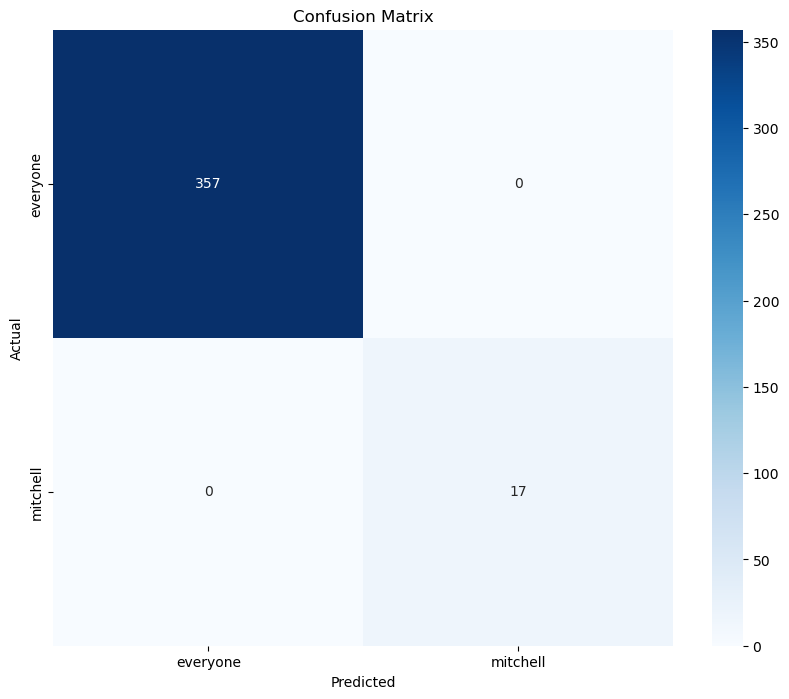

In [25]:
# Evaluate on the training set
evaluate_model(lenet5, train_loader, device, data.classes)

Accuracy: 100.00%
Balanced Accuracy: 100.00%
Macro F1 Score: 1.0000


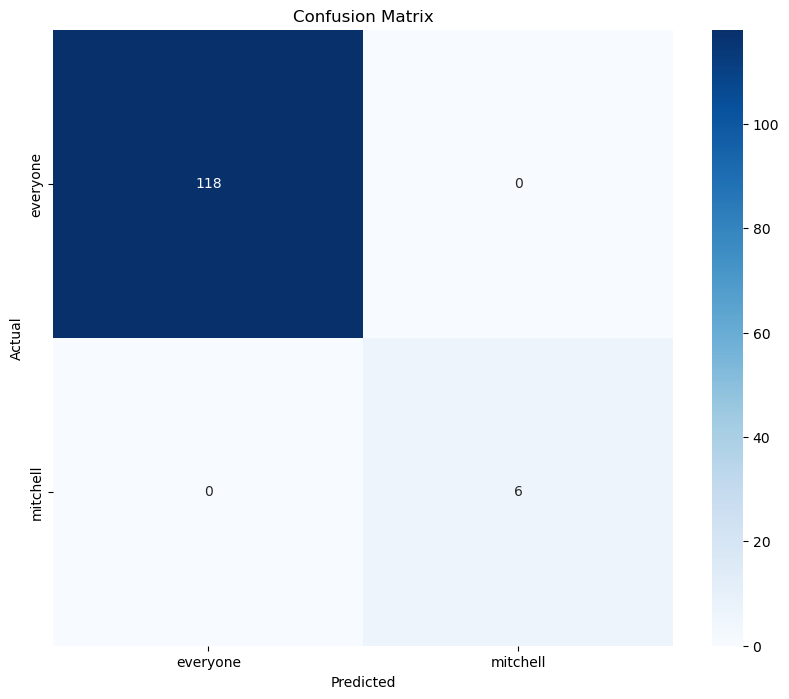

In [26]:
# Evaluate on the val set
evaluate_model(lenet5, val_loader, device, data.classes)

Accuracy: 100.00%
Balanced Accuracy: 100.00%
Macro F1 Score: 1.0000


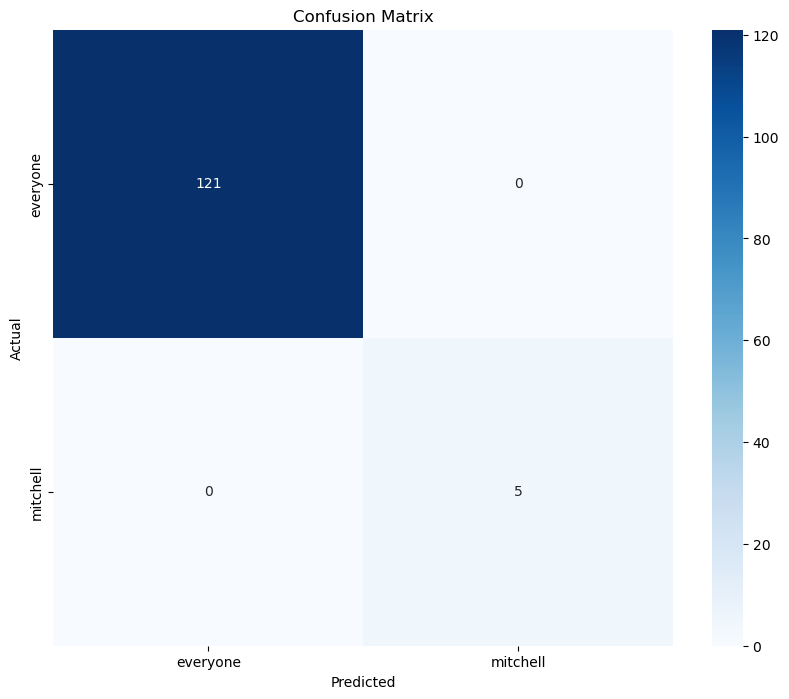

In [27]:
# Evaluate on the test set
evaluate_model(lenet5, test_loader, device, data.classes)

In [28]:
def visualize_predictions(model, data_loader, class_names, device, original_size, num_images=5):
    model.eval()  # Set the model to evaluation mode

    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    
    indices = random.sample(range(images.size(0)), num_images)
    selected_images = images[indices]
    selected_labels = labels[indices]

    with torch.no_grad():
        outputs = model(selected_images)
        _, predicted_labels = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i, idx in enumerate(indices):
        image = selected_images[i].cpu()
        image = TF.resize(image, original_size) # Resize to original size
        image = image.numpy().transpose((1, 2, 0))
        image = image * 0.5 + 0.5  # Reverse normalization

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Ground truth: {class_names[selected_labels[i].item()]}\nPrediction: {class_names[predicted_labels[i].item()]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

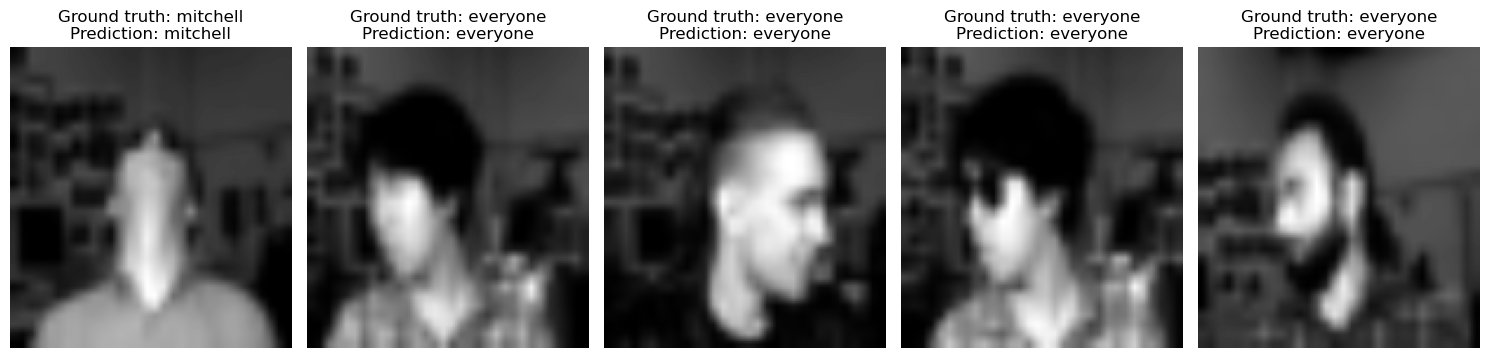

In [29]:
visualize_predictions(lenet5, test_loader, data.classes, device, original_size=(128, 120), num_images=5)

# Feature visualization

In [30]:
def visualize_feature_maps(model, image, layers_to_visualize=None):
    model.eval()

    # Forward hook to store the output of each layer
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    hooks = []
    for name, layer in model.named_children():
        if isinstance(layer, nn.Conv2d): 
            if layers_to_visualize is None or name in layers_to_visualize:
                hooks.append(layer.register_forward_hook(hook_fn))

    image = image.unsqueeze(0).to(next(model.parameters()).device)  
    _ = model(image)

    for hook in hooks:
        hook.remove()

    for i, activation in enumerate(activations):
        num_filters = activation.shape[1]  # Number of filters
        fig, axes = plt.subplots(1, num_filters, figsize=(15, 15))
        fig.suptitle(f'Layer {i + 1} Feature Maps', fontsize=16)
        for idx in range(num_filters):
            axes[idx].imshow(activation[0, idx].detach().cpu().numpy(), cmap='gray')
            axes[idx].axis('off')
        plt.show()

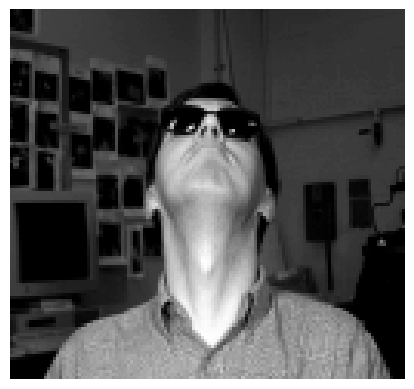

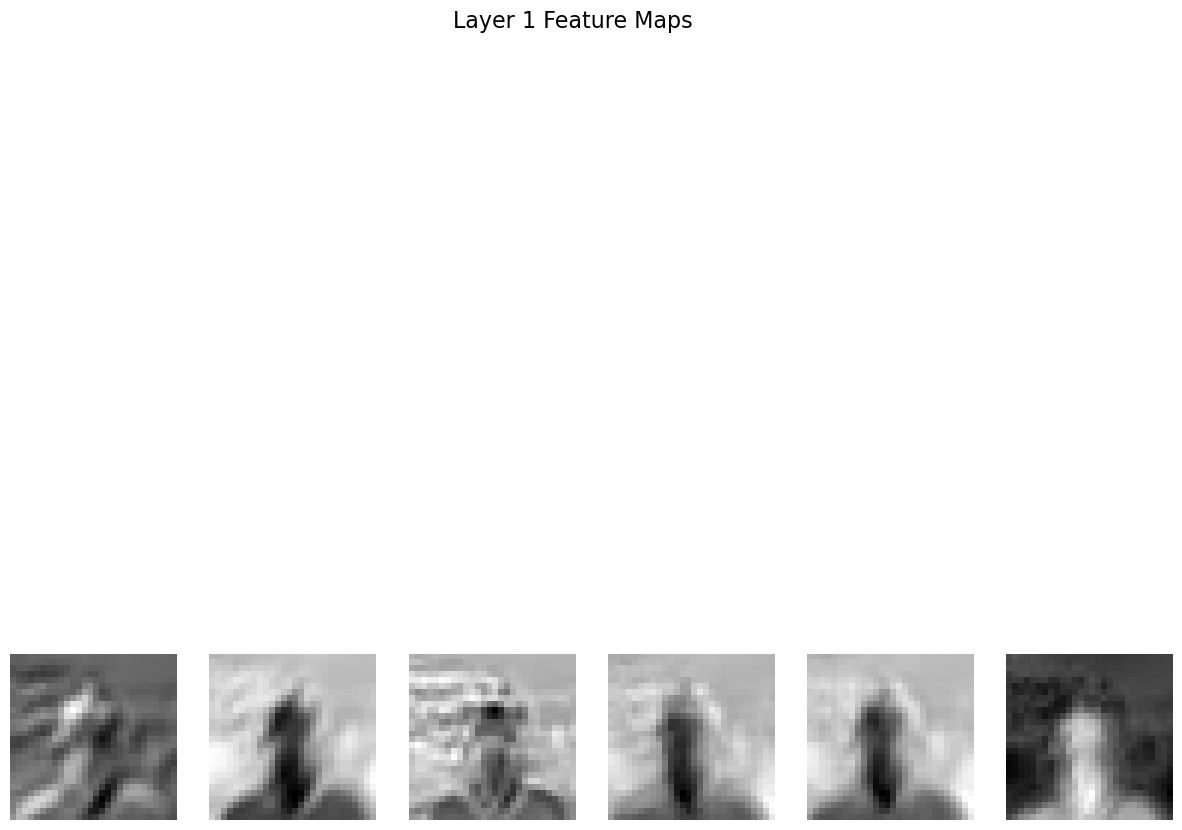

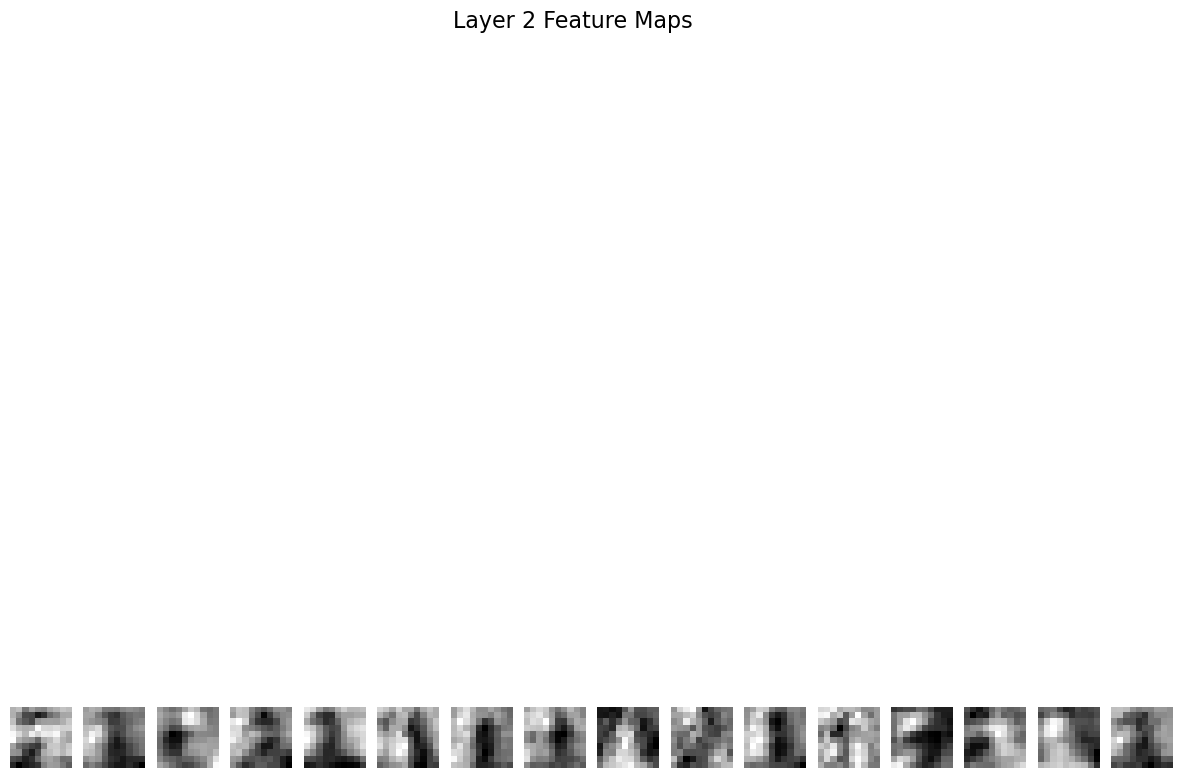

In [31]:
idx = -1
image, label = data[idx]  
image_path, label = data.samples[idx]

display_image = Image.open(image_path)
plt.imshow(display_image, cmap='gray')
plt.axis('off')  
plt.show()

visualize_feature_maps(lenet5, image, layers_to_visualize=['conv1', 'conv2'])

# Getting insights about the results using GradCam

In [32]:
target_layer = lenet5.conv2  # Target the second convolutional layer in LeNet-5
gradcam = GradCAM(lenet5, target_layer)
gradcam_pp = GradCAMpp(lenet5, target_layer)

In [33]:
def visualize_image_with_gradcam(data, idx, class_names, model, gradcam, gradcam_pp):
    image, label = data[idx]

    image = image.to(next(model.parameters()).device)
    model.eval()  

    # Perform the forward pass to get the logits
    with torch.no_grad():
        logits = model(image.unsqueeze(0))  
        _, predicted = torch.max(logits, 1)
        predicted_label = predicted.item()

    # Generate the Grad-CAM mask
    mask, _ = gradcam(image.unsqueeze(0))
    heatmap, result = visualize_cam(mask, image)

    # Generate the Grad-CAM++ mask
    mask_pp, _ = gradcam_pp(image.unsqueeze(0))
    heatmap_pp, result_pp = visualize_cam(mask_pp, image)


    plt.figure(figsize=(10, 10))

    plt.subplot(1, 4, 1)
    original_image = np.transpose(image.cpu().numpy(), (1, 2, 0))  
    original_image = original_image * 0.5 + 0.5  # Reverse normalization
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Label: {class_names[label]} | Pred: {class_names[predicted_label]}')

    # Grad-CAM Heatmap
    plt.subplot(1, 4, 2)
    heatmap = np.transpose(heatmap.squeeze().cpu().numpy(), (1, 2, 0))
    plt.imshow(original_image, cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=0.5) 
    plt.title('Grad-CAM')

    # Grad-CAM++ Heatmap
    plt.subplot(1, 4, 3)
    heatmap_pp = np.transpose(heatmap_pp.squeeze().cpu().numpy(), (1, 2, 0))
    plt.imshow(original_image, cmap='gray')
    plt.imshow(heatmap_pp, cmap='jet', alpha=0.5)  #
    plt.title('Grad-CAM++')

    # Overlay
    plt.subplot(1, 4, 4)
    combined_image = original_image + heatmap_pp
    combined_image = combined_image / np.max(combined_image)  
    plt.imshow(combined_image, cmap='gray')
    plt.title('Overlay')

    plt.show()

    print(f'Original label: {class_names[label]}')
    print(f'Predicted label: {class_names[predicted_label]}')

/Users/vivianamarquez/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/Users/vivianamarquez/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/gradcam/gradcam.py:81: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
/Users/vivianamarquez/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/gradcam/gradcam.py:147: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', alig

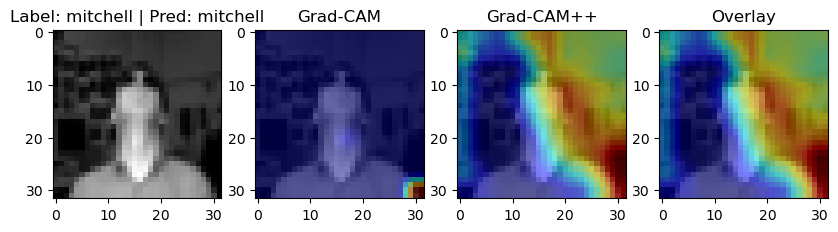

Original label: mitchell
Predicted label: mitchell


In [34]:
idx = -1  # You can change this index to select a different image
visualize_image_with_gradcam(data, idx, data.classes, lenet5, gradcam, gradcam_pp)